<a href="https://colab.research.google.com/github/LinoyEliyahu/EqualityAI/blob/main/Deepfloyd_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

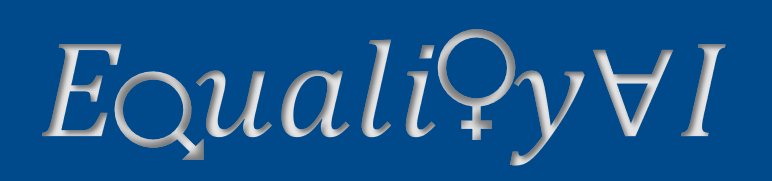


Running EqualityAI on a Free Tier Google Colab

We show how to run open-source text to image models and get a fair gender distribution results on a free-tier Google Colab.


## Available resources

The free-tier Google Colab comes with around 13 GB CPU RAM:

In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13294264 kB


And an NVIDIA T4 with 15 GB VRAM:

In [ ]:
!nvidia-smi

Mon Jun 26 14:57:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install dependencies

Some optimizations can require up-to-date versions of dependencies. If you are having issues, please double check and upgrade versions.

In [ ]:
! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  safetensors~=0.3 \
  sentencepiece~=0.1 \
  accelerate~=0.18 \
  bitsandbytes~=0.38 \
  torch~=2.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.5 MB/s eta 0:00:00


In [ ]:
! pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=0ac97087cc9102408f6c19326d465621e46b54fc44f247ae25423fdd32375926
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import gc
from matplotlib import pyplot as plt
from deepface import DeepFace
from retinaface import RetinaFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


## ImageGenerator

Use StableDiffusion to generate several images for an occupation.

In [ ]:

class ImageGenerator(object):
  def __init__(self, prompt, num_images=10):
    self.pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16",
                                                    torch_dtype=torch.float16)
    self.pipe.to("cuda")
    self.prompt = prompt
    self.num_images = num_images

  def generate_single_image(self):
    image = self.pipe(self.prompt).images[0]

    '''
    If at some point you get a black image, it may be because the content filter
    built inside the model might have detected an NSFW result.
    If you believe this shouldn't be the case, try tweaking your prompt or
    using a different seed.
    '''
    return image

  def save_image(self, image_obj, file_name=""):
    if not file_name:
      file_name = self.prompt.replace(" ", "_")
    if type(image_obj) is list:
      for i, img in enumerate(image_obj):
        img.save("{file_name}.png".format(file_name="{file_name}_{index}".format
         (file_name=file_name, index=i)))

    else:
        image_obj.save("{file_name}.png".format(file_name=file_name))

  def image_grid(self, imgs, rows, cols):
    # generate several images of the same prompt at once
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
      grid.paste(img, box=(i % cols * w, i // cols * h))

    return grid

  def generate_multiple_images(self):
    images = []

    for i in range(self.num_images):
      image = self.generate_single_image()
      images.append(image)

    return images

  def delete(self):
    del self.pipe
    gc.collect()
    torch.cuda.empty_cache()



## EqualityAI

Use DeepFace and ImageGenerator to return fair gender distribution images for an occupation.

In [ ]:

class EqualityAI(object):
  def __init__(self, occupation, num_images=10):
    self.occupation = occupation
    self.num_images = num_images

    self.men_images = []
    self.women_images = []
    self.output_images = []

    self.countGoodImg = 0
    self.fixer_counter = 0
    self.min_gender_amount = 2

    self.prompt = "one {} face photo".format(occupation)
    self.set_generator(self.prompt)

  def set_generator(self, prompt):
    self.img_gen = ImageGenerator(prompt)

  def get_images(self):
    # Generate the amount of images of the same occupations
    # save each image by its gender

    for i in range(0, self.num_images):
      single_img = self.img_gen.generate_single_image()
      img_path = "{}_{}".format(self.occupation, self.countGoodImg)

      self.img_gen.save_image(single_img, img_path)
      try:
        objs = DeepFace.analyze(img_path="{}.png".format(img_path), actions='gender')
        current_gender = objs[0]['dominant_gender']

        # skip unknown gender
        if (objs[0]['gender'][current_gender] < 75) or (len(objs) > 2):
          continue

        print('{} Gender = {}'.format(img_path, current_gender))

        if(current_gender == 'Man'):
          self.men_images.append("{}.png".format(img_path))
        else:
          self.women_images.append("{}.png".format(img_path))
        self.countGoodImg += 1

      except Exception as e:
        print("Exception: ")
        print(e)
        i -= 1
        continue

    if len(self.men_images) < self.min_gender_amount:
      self.fixer('men')
    elif len(self.women_images) < self.min_gender_amount:
      self.fixer('women')
    else:
      print('Men = {},  Women = {}'.format(len(self.men_images), len(self.men_images)))

  def fixer(self, gender):
    self.fixer_counter += 1
    if (self.fixer_counter > 3):
      print("Too many fixer iterations, fixing is not helping")
      return
    print('Fixer iteration {} - current state: Men = {}, Women = {} '.format(self.fixer_counter,
          len(self.men_images), len(self.women_images)))
    print('need to add more images of {} {}'.format(gender, self.occupation))
    self.prompt = "{} {}".format(self.prompt, gender)

    try:
      self.img_gen.delete()
    except:
      print("img_gen not exist")
    self.set_generator(self.prompt)
    self.get_images()

    print('Fixer iteration {} - After fix: Men = {}, Women = {} '.format(self.fixer_counter,
          len(self.men_images), len(self.women_images)))

  def output(self):
    try:
      self.img_gen.delete()
    except:
      print("img_gen not exist")
    # we return 4 imgs to the user:
    for i in range(0, self.min_gender_amount):
      try:
        img_man = self.men_images.pop()
        self.output_images.append(img_man)
      except:
        print("Not enough MEN images")
      try:
        img_woman = self.women_images.pop()
        self.output_images.append(img_woman)
      except:
        print("Not enough WOMEN images")
    return self.output_images



unet/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [02:08<00:00, 4.17MB/s]


Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

FireFighter_0 Gender = Man


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

FireFighter_1 Gender = Man


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

FireFighter_2 Gender = Woman


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

FireFighter_3 Gender = Man


  0%|          | 0/50 [00:00<?, ?it/s]

Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

FireFighter_4 Gender = Man


  0%|          | 0/50 [00:00<?, ?it/s]

Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

FireFighter_5 Gender = Man


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Fixer iteration 1 - current state: Men = 5, Women = 1 
need to add more images of women FireFighter


unet/diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

FireFighter_6 Gender = Man


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

FireFighter_7 Gender = Woman


  0%|          | 0/50 [00:00<?, ?it/s]

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


  0%|          | 0/50 [00:00<?, ?it/s]

Exception: 
Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Men = 6,  Women = 6
Fixer iteration 1 - After fix: Men = 6, Women = 2 


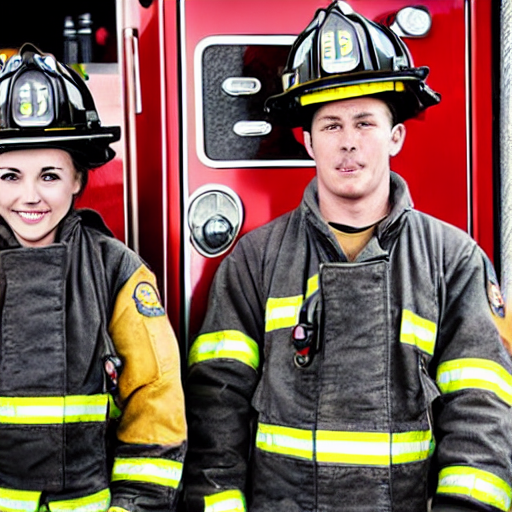

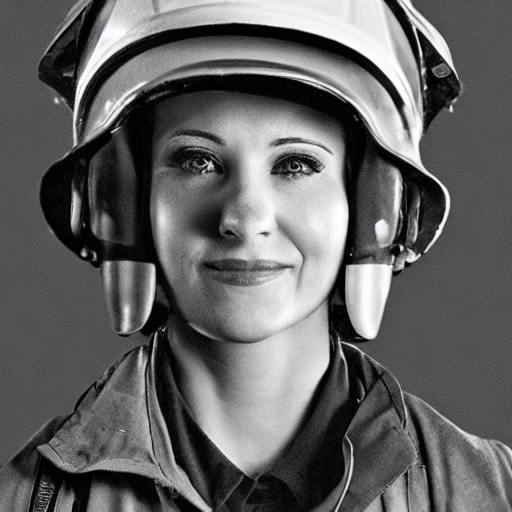

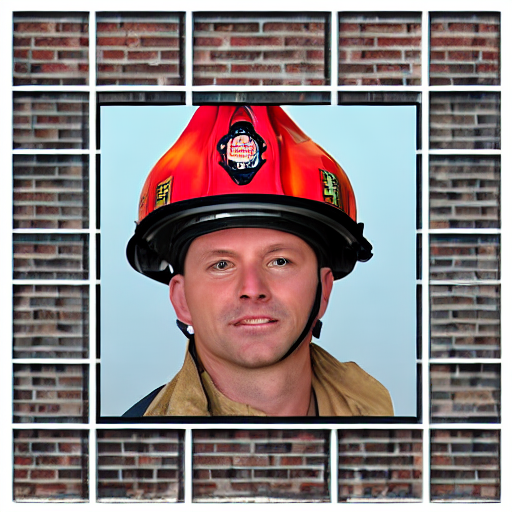

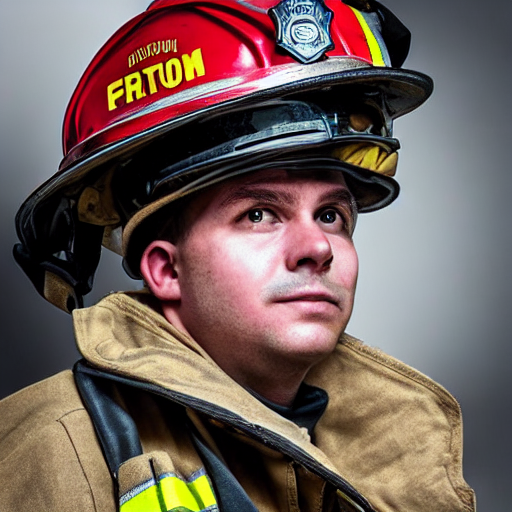

In [ ]:
# main:
from IPython.display import Image, display

# Text-to-image input:
occupation = input("Enter an occupation: ")

eqai = EqualityAI(occupation)
eqai.get_images()

res = eqai.output()
for img in res:
  display(Image(img))


## old code:

In [ ]:
from deepface import DeepFace
#from retinaface import RetinaFace
men = 0
women = 0
countGoodImg = 0

for i,img in enumerate(multi_img):
  img_name = "multi_img_" + str(i) +".png"
  #faces = RetinaFace.extract_faces(img_name)
  # while(len(faces) == 0):
    # single_img = deepf.generate_single_image()
    # deepf.save_image(single_img, img_name)
  # face_obj = DeepFace.extract_faces(img_path = img_name)
  # print(face_obj)
    # faces = RetinaFace.extract_faces(img_name)
  try:
    objs = DeepFace.analyze(img_path = img_name,
       actions = 'gender')
    print(objs[0]['dominant_gender'])
    countGoodImg += 1
  except Exception:
    multi_img.append(deepf.generate_single_image())
    deepf.save_image(multi_img, "multi_img_" + str(len(multi_img)) +".png")
    countGoodImg += 1
  if(objs[0]['dominant_gender'] == 'Man'):
      men += 1
  else:
      women += 1

  if (countGoodImg == 10) :
    break

print(men, women)
